### Connectome-informed reservoir - Echo-State Network

This tutorial demonstrates how to use the conn2res toolbox to implement
a NeuroGym task varying both local and global dynamics.

In [1]:
%matplotlib inline

import warnings
import os
import numpy as np
import pandas as pd
from sklearn.base import is_classifier
from conn2res.tasks import NeuroGymTask
from conn2res.connectivity import Conn
from conn2res.reservoir import EchoStateNetwork
from conn2res.readout import Readout
from conn2res import readout, plotting

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

First, let's initialize some constant variables.

In [2]:
# name of the task to be performed
TASK = 'PerceptualDecisionMaking'

# define metrics to evaluate readout's model performance
METRICS = [
    'balanced_accuracy_score',
    'f1_score',
]

# define alpha values to vary global reservoir dynamics
ALPHAS = np.linspace(0, 2, 11)[1:]

# activation function defines local dynamics
ACT_FCN = 'tanh'  # 'sigmoid'

Second, let's fetch a NeuroGym task data set.

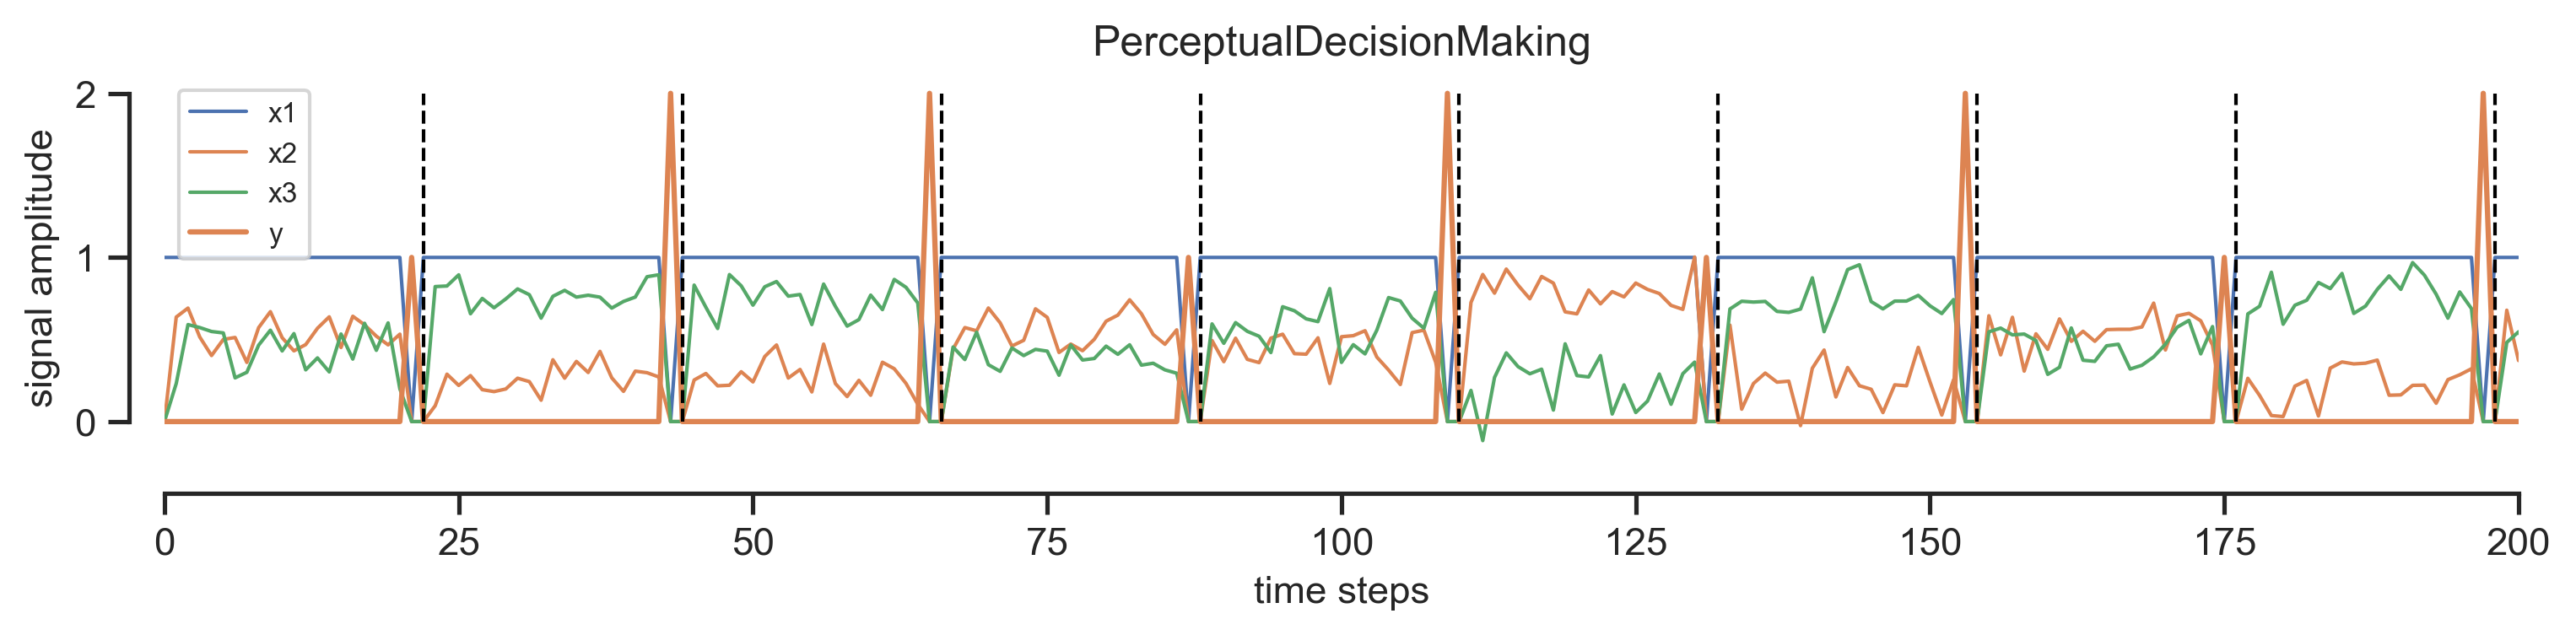

In [3]:
# instantiate task object
task = NeuroGymTask(name=TASK)

# fetch input/output data to perform task
x, y = task.fetch_data(n_trials=1000)

# plot input/output (x/y) data
plotting.plot_iodata(
    x, y, title=task.name,
    show=True
)

# split data into training and test sets
x_train, x_test, y_train, y_test = readout.train_test_split(x, y)

Third, let's import the connectivity matrix we are going to use to define the connections of the reservoir.  

For this we will be using the human connectome parcellated into 1015 brain regions following the Desikan Killiany atlas (Desikan, et al., 2006).

In [4]:
# load connectivity data of one subject
conn = Conn(subj_id=0)

# scale conenctivity weights between [0,1] and normalize by spectral its
# radius
conn.scale_and_normalize()

Let's define the set of input and output nodes.

To do so, we will use functional intrinsic networks (Yeo ,et al., 2011).

In [5]:
# input nodes: a random set of brain regions in the visual system
input_nodes = conn.get_nodes(
    'random', nodes_from=conn.get_nodes('VIS'),
    n_nodes=task.n_features
)

In [6]:
# output nodes: all brain regions in the somatomotor system
output_nodes = conn.get_nodes('SM')

Now we will create the input connectivity matrix to define the connections between the input layer (source nodes where the input signal is coming from) and the input nodes in the reservoir.

In [7]:
w_in = np.zeros((task.n_features, conn.n_nodes))
w_in[:, input_nodes] = np.eye(task.n_features)

Next, we will simulate the dynamics of the reservoir. We will evaluate the effect of local network dynamics by using different activation functions. We will also evaluate network performance across dynamical regimes by parametrically tuning alpha, which corresponds to the spectral radius of the connectivity matrix (alpha parameter).

In [8]:
# instantiate an Echo State Network object
esn = EchoStateNetwork(w=conn.w, activation_function=ACT_FCN)

# instantiate a Readout module object
readout_module = Readout(estimator=readout.select_model(y))


			----- alpha = 0.2 -----

			----- alpha = 0.4 -----

			----- alpha = 0.6 -----

			----- alpha = 0.8 -----

			----- alpha = 1.0 -----


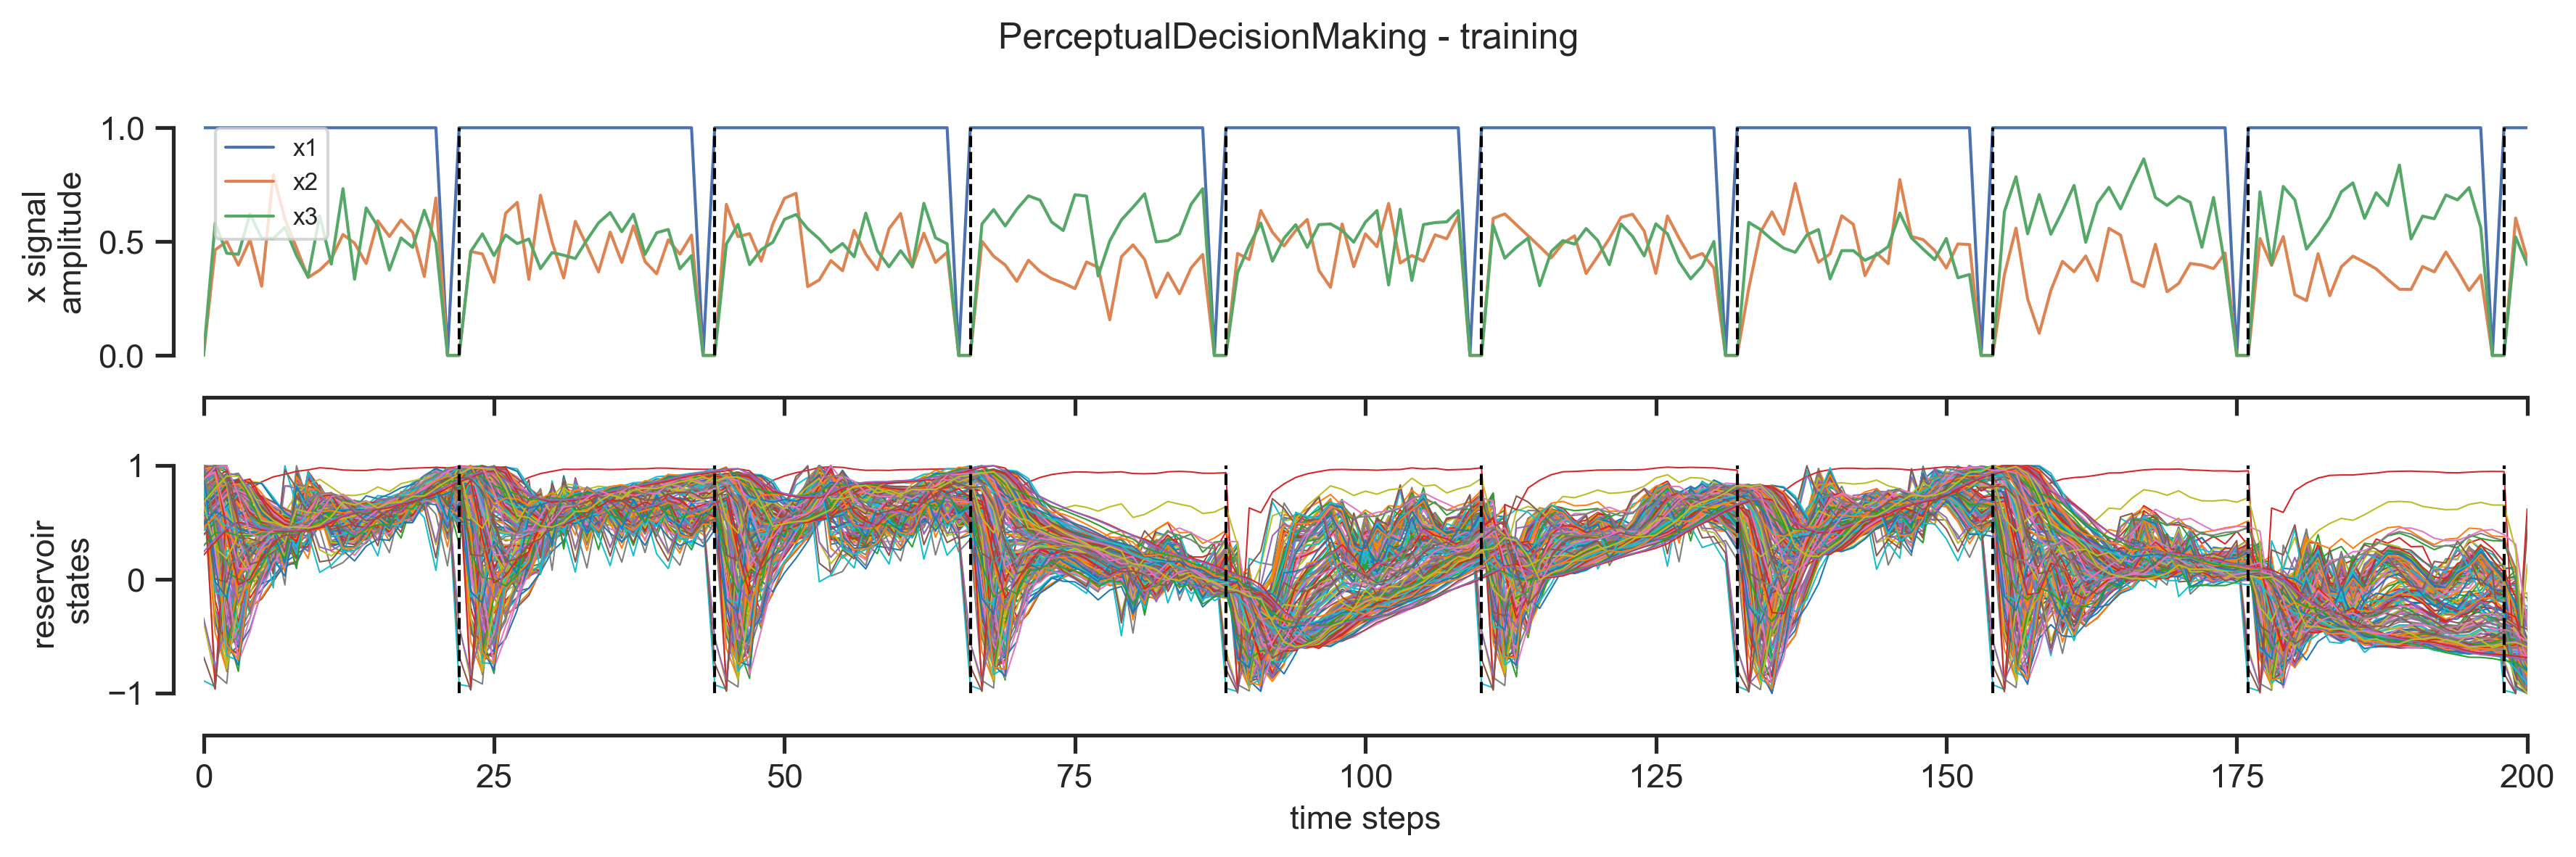

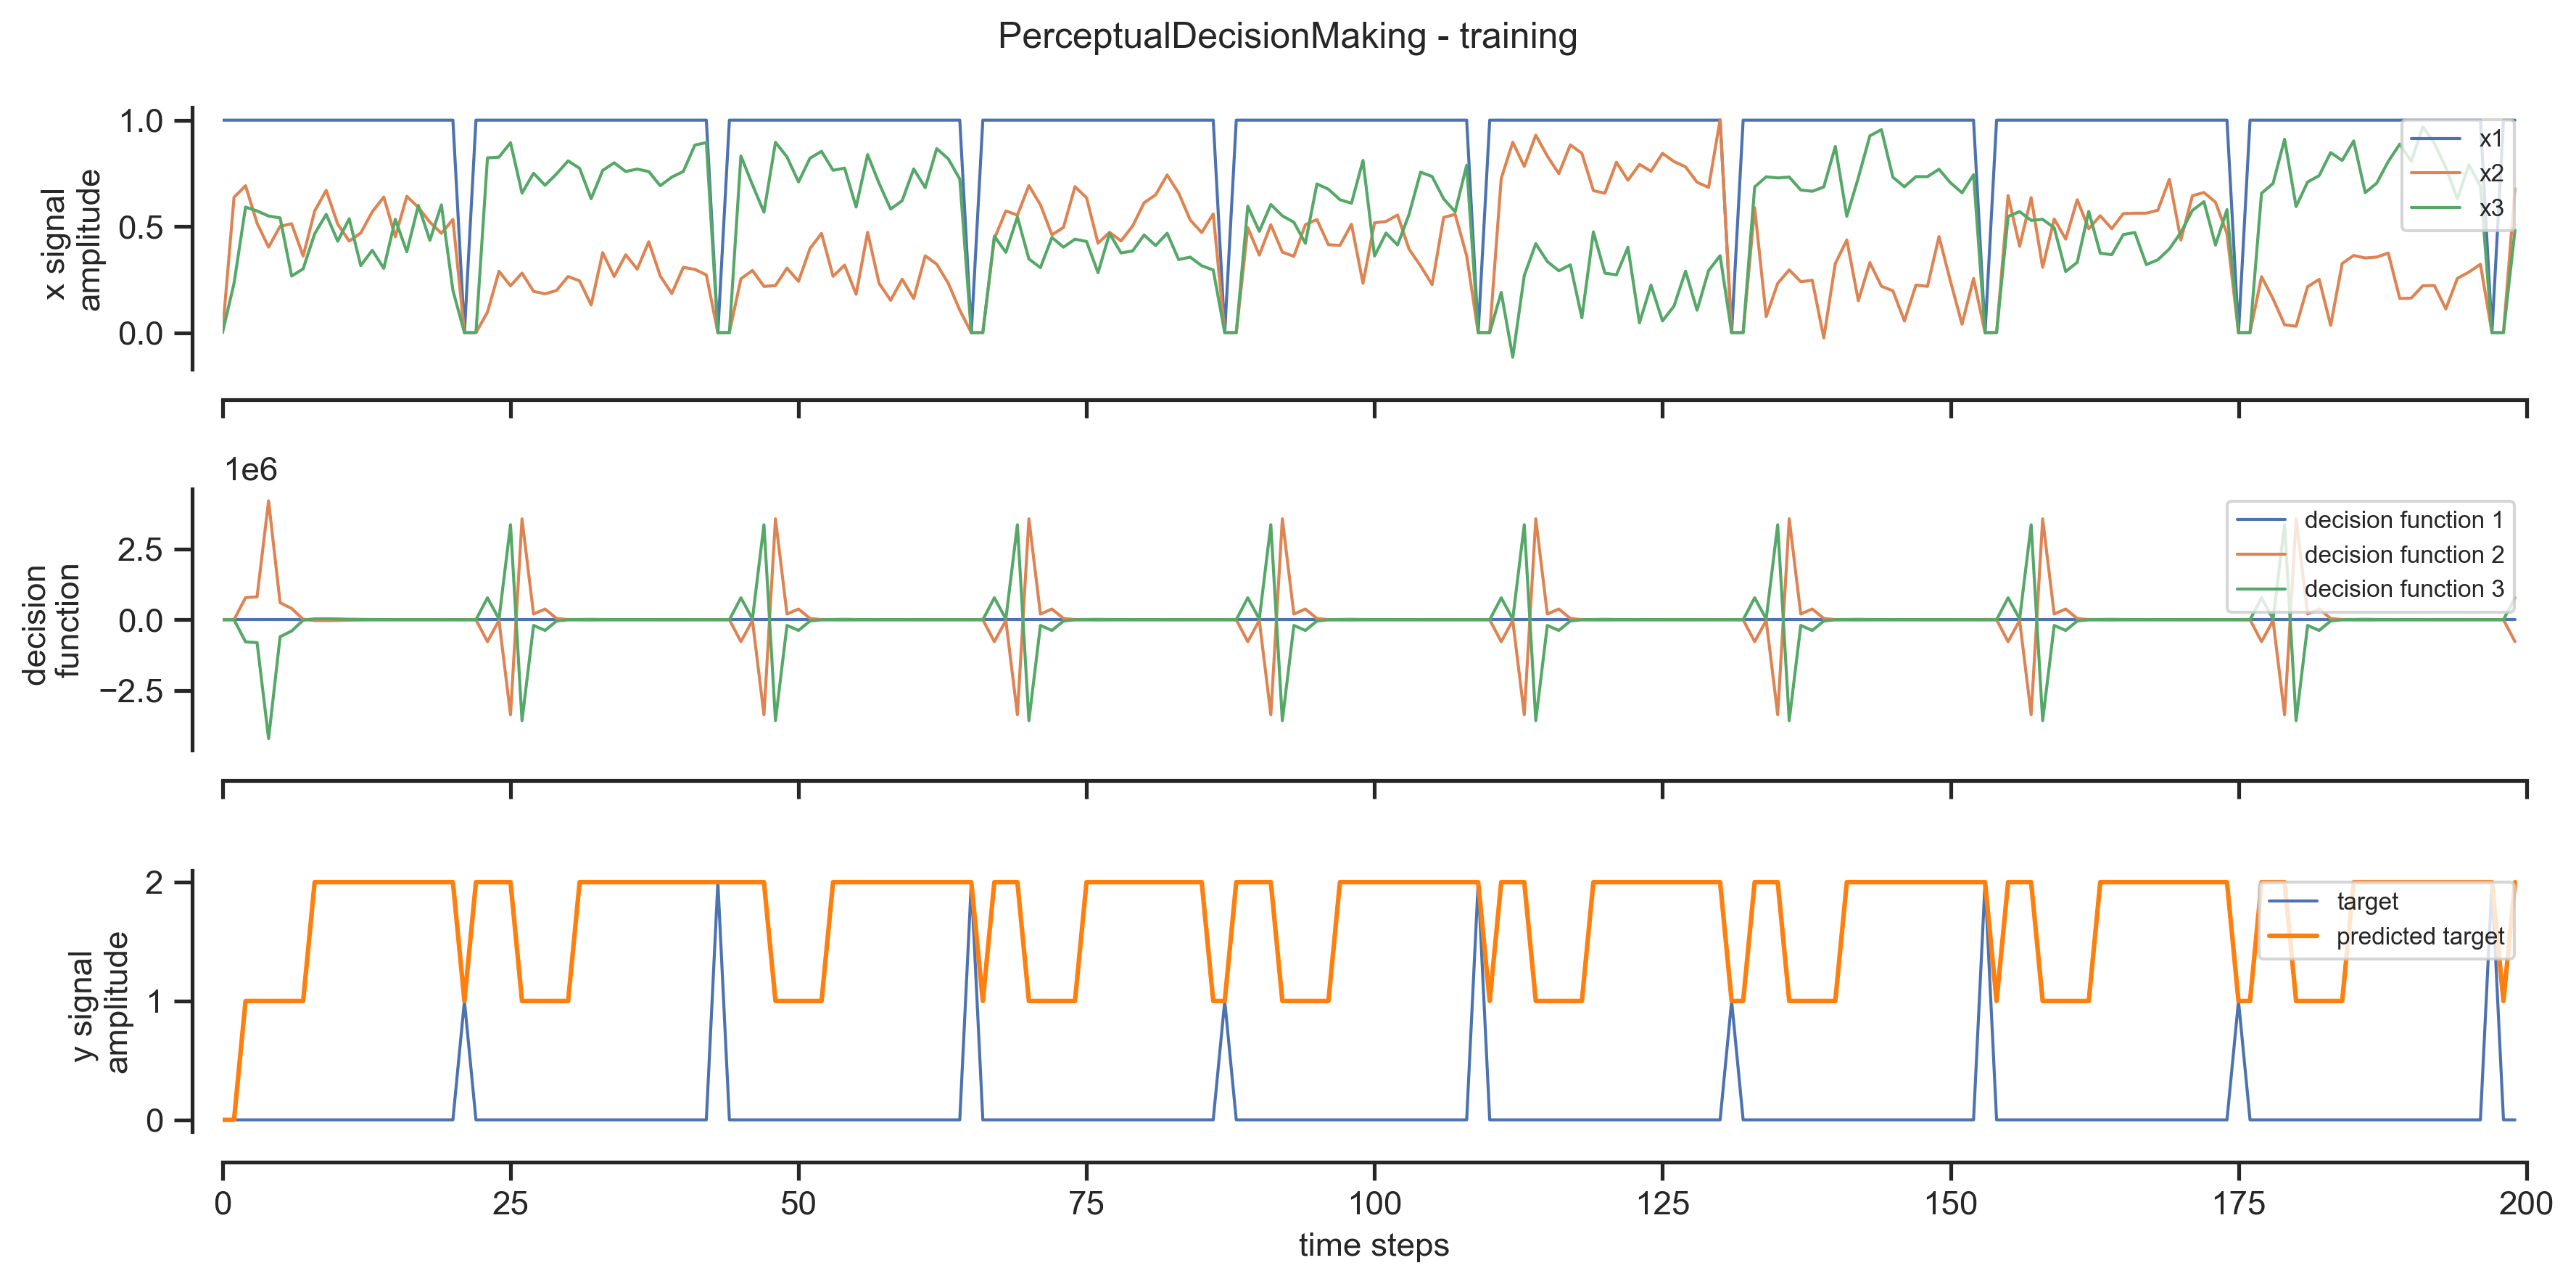

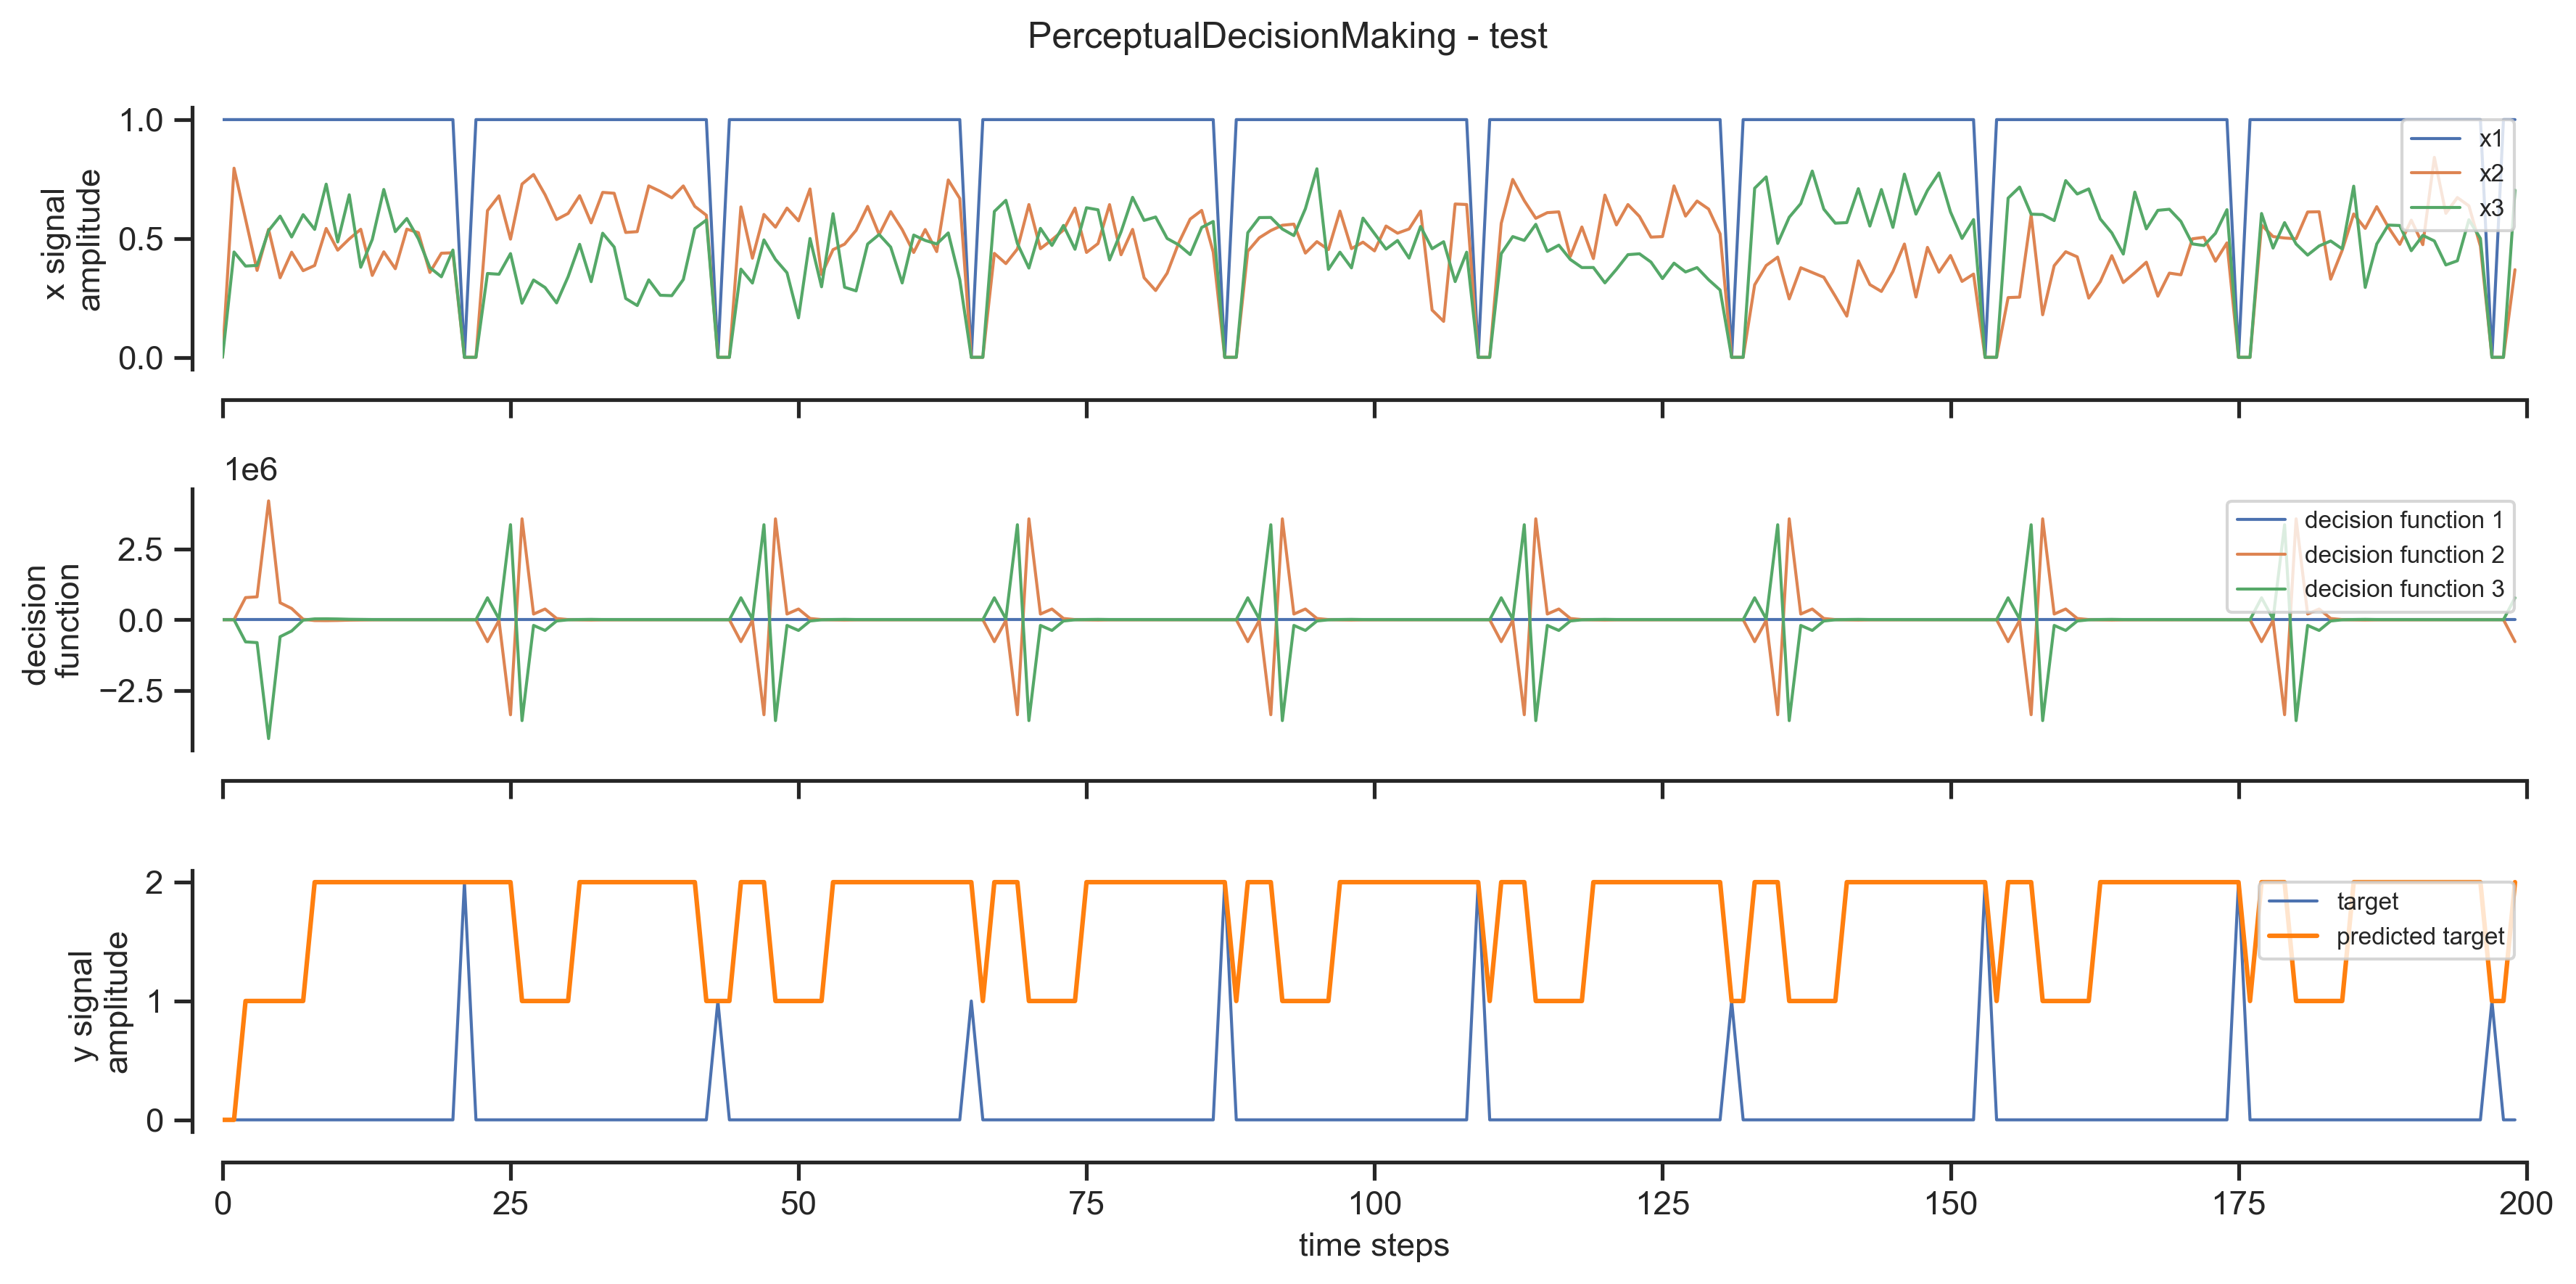


			----- alpha = 1.2 -----

			----- alpha = 1.4 -----

			----- alpha = 1.6 -----

			----- alpha = 1.8 -----

			----- alpha = 2.0 -----


In [9]:
 # iterate global dynamics using different alpha values
df_alpha = []
for alpha in ALPHAS:

    print(f'\n\t\t\t----- alpha = {np.round(alpha,2)} -----')

    # scale connectivity matrix by alpha
    esn.w = alpha * conn.w

    # simulate reservoir states
    rs_train = esn.simulate(
        ext_input=x_train, w_in=w_in, input_gain=1,
        output_nodes=output_nodes
    )

    rs_test = esn.simulate(
        ext_input=x_test, w_in=w_in, input_gain=1,
        output_nodes=output_nodes
    )

    # plot reservoir states
    if alpha == 1.0:
        plotting.plot_reservoir_states(
            x=x_train, reservoir_states=rs_train,
            title=f'{task.name} - training',
            show=True
        )

        # plotting.plot_reservoir_states(
        #     x=x_test, reservoir_states=rs_test,
        #     title=f'{task.name} - test',
        #     show=True
        # )

    # perform task
    df_res = readout_module.run_task(
        X=(rs_train, rs_test), y=(y_train, y_test),
        sample_weight='both', metric=METRICS,
        readout_modules=None, readout_nodes=None,
    )

    # assign column with alpha value and append df_res
    # to df_alpha
    df_res['alpha'] = np.round(alpha, 3)
    df_alpha.append(df_res)

    # plot decision-making function
    if alpha == 1.0:
        plotting.plot_diagnostics(
            x=x_train, y=y_train, reservoir_states=rs_train,
            trained_model=readout_module.model, title=f'{task.name} - training',
            show=True
        )
        plotting.plot_diagnostics(
            x=x_test, y=y_test, reservoir_states=rs_test,
            trained_model=readout_module.model, title=f'{task.name} - test',
            show=True
        )
           
# concatenate results across alpha values
df_alpha = pd.concat(df_alpha, ignore_index=True)

Finally, let's visualize task performance.

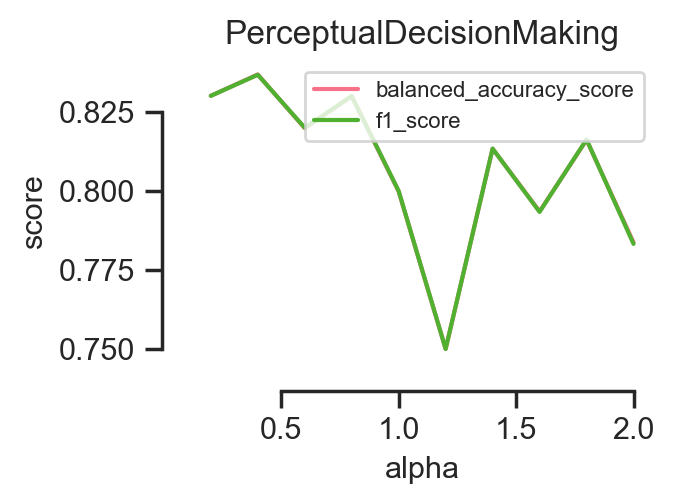

In [10]:
from conn2res import plotting

df = pd.melt(df_alpha, 
             id_vars=['alpha'], 
             value_vars=['balanced_accuracy_score', 'f1_score'], 
             var_name='metric', 
             value_name='score'
            )


plotting.plot_performance(
        df, 
        x='alpha', y='score', 
        hue='metric',
        title=task.name,
        show=True
    )

End of Tutorial !!!